### Performing Quality Control and Clustering on scRNA-seq data for DPD-deficiency Study

**General Notes**
1) The following documentation(s) have been used for the analysis performed in this notebook,
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html#Preprocessing

2) The results of the paper can be reproduced with the following versions of the libraries, \
scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.2 scipy==1.6.2 pandas==1.1.3 \
scikit-learn==0.24.1 statsmodels==0.11.1 python-igraph==0.9.8 louvain==0.7.0 pynndescent==0.5.5

Also, before loading python, **PYTHONHASHSEED** should be set to zero. Reference for setting the PYTHONHASHSEED for reproducibility:
https://github.com/theislab/scanpy/issues/313

3) It is very likely that you may not be able to reproduce the results due to version changes,
in this case simply load `DPD_res.h5ad` (set `load_adata=True`), which is the adata produced after quality control and clustering.
In case you do the clustering from scratch, you have to do cell type annotation following the procedure explained in the paper.

**Sequenece of Analysis**
1) Performing quality control on the single cell data from one affected individual and one non-affected individual. 
2) Clustering of cells using Leiden algorithm. 
3) Hierarchical clustering of cells using neuronal and non-neuronal marker genes. 
4) Finding the markers of each cluster by t-test. 
5) Taking the overlap of markers for each cluster with the cell type markers in Tanaka et al. study. 
6) Saving the processed cells along with their cluster id for signature and pseudo-bulk mixture generation.

In [1]:
import os
from os import listdir
from os.path import isfile, join

import numpy as np
import pandas as pd
import scanpy as sc

from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# you should merge all the cells from different organoids in one file 
# and produce the barcode.tsv and genes_data.tsv for them as well as the matrix.mtx file

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

load_path= "dpd_data/scdata"
save_path= f"./dpd_results/sc_preprocess/"
seed= 0

# to save the adata
os.makedirs(f'{save_path}/write', exist_ok= True)
results_file = f'{save_path}/write/DPD_res.h5ad' # the file that will store the analysis results

# load the adata generated in the project (True) or do the preprocessing from scratch (False)
load_adata = True

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.2 scipy==1.6.2 pandas==1.1.3 scikit-learn==0.24.1 statsmodels==0.11.1 python-igraph==0.9.8 louvain==0.7.0 pynndescent==0.5.5


Loading adata from paper analysis
No cell type annotation is required


... storing 'Cell Type' as categorical


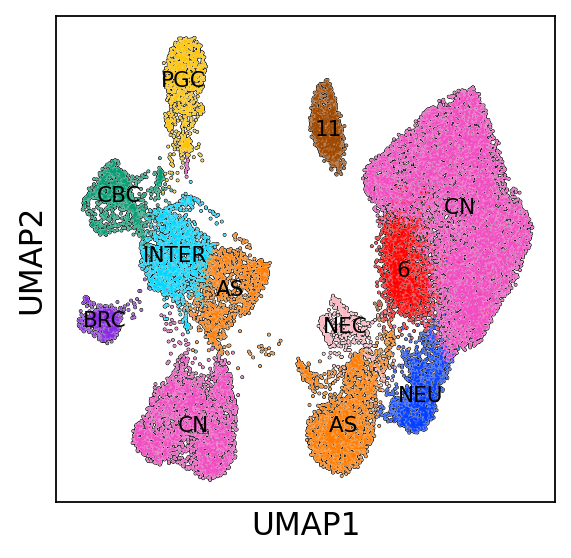

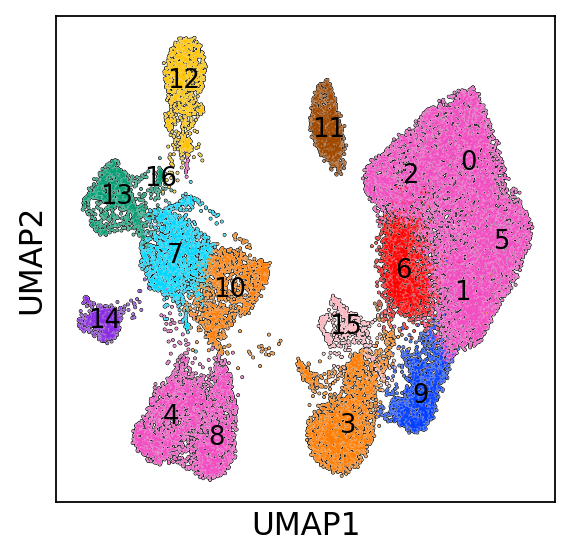

In [3]:
if load_adata and os.path.exists("dpd_data/sc_preprocess/write/DPD_res.h5ad"):
    print("Loading adata from paper analysis\nNo cell type annotation is required")
    adata = sc.read('dpd_data/sc_preprocess/write/DPD_res.h5ad')
    
    # map the cluster indices to CT names
    # note that this is done according to the cell type annotation 
    # procedure explained in the paper
    clst_ct_map_ds= {"0": "CN-DPD", "1": "CN-DPD", "2": "CN-DPD", "3": "AS-DPD", 
                     "4": "CN-H", "5": "CN-DPD", "6": "6", "7": "INTER", "8": "CN-H", "9": "NEU", 
                     "10": "AS-H", "11": "11", "12": "PGC", "13": "CBC", "14": "BRC", "15": "NEC", "16": "CBC"}

    clst_ct_map= {"0": "CN ", "1": "CN ", "2": "CN ", "3": "AS ", 
                  "4": "CN", "5": "CN ", "6": "6", "7": "INTER", "8": "CN", "9": "NEU", 
                  "10": "AS", "11": "11", "12": "PGC", "13": "CBC", "14": "BRC", "15": "NEC", "16": "CBC"}
    adata.obs["Cell Type"] = adata.obs["clusters"].map(clst_ct_map)



    tmp_pal= sns.color_palette("bright", 10)
    c_dark_blue, c_orange, c_light_green, c_red, c_purple= tmp_pal[:5]
    c_brown, c_pink, c_grey, c_yellow, c_light_blue= tmp_pal[5:]

    pal_blind = sns.color_palette("colorblind", 10)
    c_green_blind = pal_blind[2]

    # paletter for cell type colors
    pal_ct_dict_ds= {"CN-DPD": c_pink, "CN-H": c_pink, "AS-H": c_orange, "AS-DPD": c_orange,
                     "CBC": c_green_blind, "INTER": c_light_blue, "PGC": c_yellow, "BRC": c_purple,
                     "NEC": "lightpink", "6": "r", "11": c_brown, "NEU": c_dark_blue}

    pal_ct_dict= {"CN ": c_pink, "CN": c_pink, "AS": c_orange, "AS ": c_orange,
                  "CBC": c_green_blind, "INTER": c_light_blue, "PGC": c_yellow, "BRC": c_purple,
                  "NEC": "lightpink", "6": "r", "11": c_brown, "NEU": c_dark_blue}

    # create palette for cluster colors
    pal_cls_dict= {}
    for cls_ind in clst_ct_map.keys():
        ct= clst_ct_map[cls_ind]
        color= pal_ct_dict[ct]
        pal_cls_dict[cls_ind]= color

    # ref: https://github.com/scverse/scanpy/issues/2112 (adding legend on the plot)
    #sc.pl.umap(adata, color=['Cell Type'], title= "", legend_fontsize= "small", 
    #           palette= pal_ct_dict,save= "_ctnames_umap_rightleg", show= True, add_outline= True)

    sc.pl.umap(adata, color=['Cell Type'], title= "", legend_loc= 'on data',
               legend_fontsize= "x-small", legend_fontweight= "medium",
               palette= pal_ct_dict, save= "_ctnames_umap_ondataleg", show= True, add_outline= True)

    #sc.pl.umap(adata, color=['clusters'], title= "", 
    #           palette= pal_cls_dict, save= "_clstr_umap_rightleg", show= True, add_outline= True)

    sc.pl.umap(adata, color=['clusters'], title= "", legend_loc= 'on data',
               legend_fontsize= "small", legend_fontweight= "medium",
               palette= pal_cls_dict, save= "_clstr_umap_ondataleg", show= True, add_outline= True)

else:
    #####################
    ### load the data ###
    #####################
    print("Creating adata from scratch\nYou should annotate the cell types.")
    
    # perform preprocessing from scratch
    # genes.tsv should have two columns the first being the ens id and the second being the gene symbol
    adata = sc.read_10x_mtx(load_path,  # the directory with the `.mtx` file
                            var_names='gene_symbols', # use gene symbols for the variable names (variables-axis index)
                            cache= True) # write a cache file for faster subsequent reading

    # subsetting to healthy or dpd or keep both of them
    healthy_brcs, dpd_brcs= [], []
    for ind in adata.obs.index:
        no= ind.strip("").split("-")[1]
        if int(no) in [4,5,6]:
            dpd_brcs.append(ind)
        else:
            healthy_brcs.append(ind)
            
            
            
    #############################################################################      
    #### extract general stats on the percentage of cells with nonzero count ####
    #### of marker genes in dpd, healthy, dpd+healthy compute the percentage ####
    ####        of cells in which each marker gene is nonzero                ####
    #############################################################################

    def nonzero_marker_stat(adata, cat):
        cell_brcs= adata.obs.index
        gene_ids= adata.var.index

        marker_dense_neuro= adata[:, neuronal_markers].X.toarray()
        marker_dense_nonneuro= adata[:, non_neuronal_markers].X.toarray()

        nonzero_pct_neuro= 100*np.mean(marker_dense_neuro > 0, axis= 0)
        nonzero_pct_nonneuro= 100*np.mean(marker_dense_nonneuro > 0, axis= 0)

        df_nonzero_marker_stat= pd.DataFrame(np.concatenate((nonzero_pct_neuro, nonzero_pct_nonneuro)), 
                                             index= neuronal_markers + non_neuronal_markers, columns= [f"{cat}_pct_nonzero"])
        return df_nonzero_marker_stat

    neuronal_markers= ['GAP43', 'STMN2', 'DCX', 'TBR1', 'EOMES', 'SLC17A7', "SLC32A1", "GAD1", "GAD2"]
    non_neuronal_markers= ['VIM', 'HES1', 'SOX2', 'BGN', 'DCN', "OLIG1", "OLIG2"]

    data_cat= ["dpd", "h", "dpd+h"]
    for i, cat in enumerate(data_cat):
        if cat == "dpd":
            adata_tmp= adata[dpd_brcs].copy()
        elif cat == "h":
            adata_tmp= adata[healthy_brcs].copy()
        else:
            adata_tmp= adata
        df_tmp= nonzero_marker_stat(adata_tmp, cat)
        df_tmp.sort_index(inplace= True)
        if i == 0:
            df= df_tmp
        else:
            df= pd.concat((df, df_tmp), axis= 1)
    os.makedirs(f"{save_path}/stats", exist_ok= True)
    df.to_csv(f"{save_path}/stats/nonzero_marker_stats", sep= "\t")

    #####################################
    ### filter on the genes and cells ###
    #####################################
    
    adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
    min_genes, min_cells= 1000, 500
    # for genes
    sc.pp.filter_cells(adata, min_genes=min_genes)
    # for cells
    sc.pp.filter_genes(adata, min_cells= min_cells)
    
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    # additional plotting
    if False:
        _ = sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                         jitter=0.4, multi_panel=True, save= f"_gc_tcount_mt", show= False)

        _= sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', save= "_tcount_mt", show= False)
        _= sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', save= "_tcount_gc", show= False)
    
    adata = adata[adata.obs.pct_counts_mt < 5, :]
    
    ##################################################
    ### Normalization/Transformation and obtaining ###
    ###        highly variable genes               ###
    ##################################################
    
    sc.pp.highly_variable_genes(adata, flavor= 'seurat_v3', n_top_genes= 2000) # similar to 'vst' mean-variance relationship in seurat v3
    # before normalization get a copy of adata
    adata_unnorm= adata.copy()

    # according to seurat v3, they normalize the data (scaling and log transformation before applying the pca)
    # perform normalization before pca
    sc.pp.normalize_total(adata, target_sum=1e4)
    adata_unnorm_beforelog= adata.copy()
    sc.pp.log1p(adata)

    highly_var_genes= list(adata.var[adata.var["highly_variable"] == True].index)
    os.makedirs(f"{save_path}/my_marker/", exist_ok= True)
    file= open(f"{save_path}/my_marker/highly_var_genes", "w")
    file.write("\n".join(highly_var_genes))
    file.close()
    
    ###########################################
    ### Performing PCA, UMAP and Clustering ###
    ###########################################
    
    sc.tl.pca(adata, svd_solver='arpack', random_state=seed) # it zero-centers the data , used scikit-learn implementation
    sc.pl.pca_variance_ratio(adata, log=True)

    # compute the neighbourhood graph
    sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, random_state= seed) # inspect the random state?

    # embedding the neighbourhood graph
    sc.tl.umap(adata, random_state= seed)
    sc.pl.umap(adata, color= None, show= False)
    
    # leidan clustering
    sc.tl.leiden(adata, key_added='clusters', resolution= 0.8, random_state= seed)
    
    # ref: https://github.com/scverse/scanpy/issues/2112 (adding legend on the plot)
    sc.pl.umap(adata, color=['clusters'], title= "", save= "_clstr_umap", show= True)

categories: 0, 1, 2, etc.
var_group_labels: NEU, Non-NEU


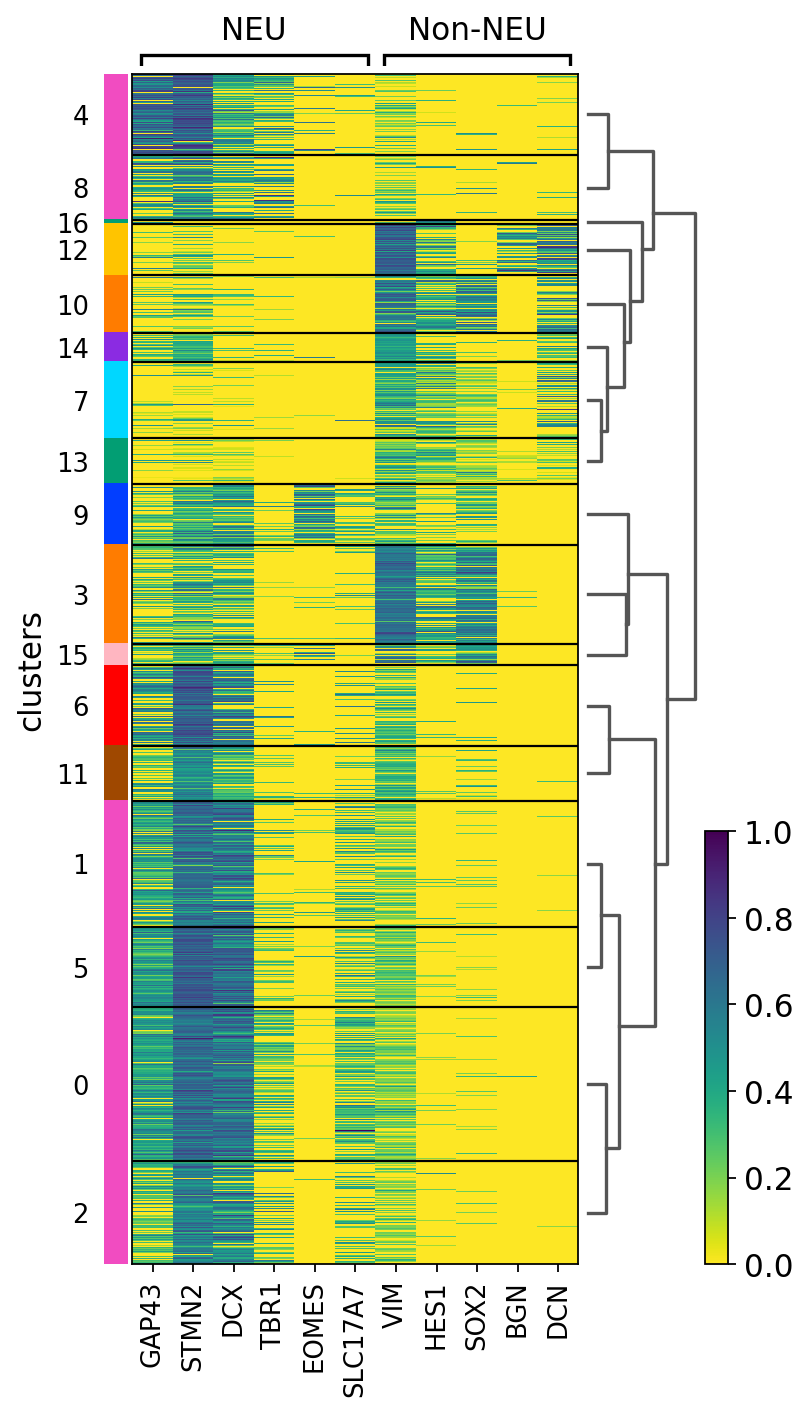

categories: 6, 11, AS, etc.
var_group_labels: NEU, Non-NEU


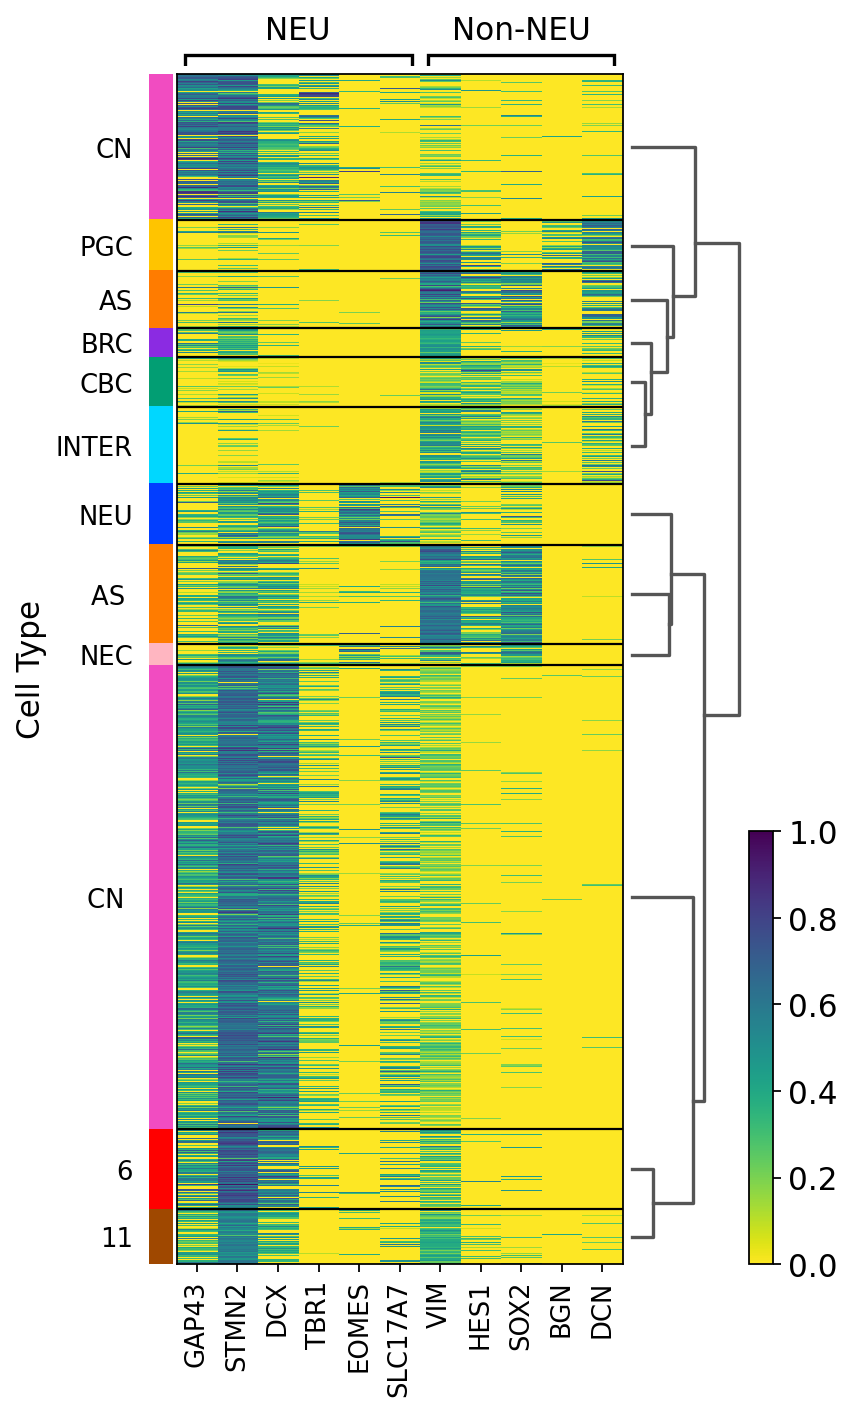

In [4]:
############################################
### Hierarchical clustering of the cells ###
### from the affected patient and the    ###
###    non-affected individual using     ###  
## neuronal and non-neuronal marker genes ##
############################################

neuronal_markers= ['GAP43', 'STMN2', 'DCX', 'TBR1', 'EOMES', 'SLC17A7']
non_neuronal_markers= ['VIM', 'HES1', 'SOX2', 'BGN', 'DCN']

marker_genes_dict= {"NEU": neuronal_markers, # leftout ['SLC32A1', 'GAD1', 'GAD2']
                    "Non-NEU": non_neuronal_markers} # leftout ['OLIG1', 'OLIG2']
color_map = plt.cm.get_cmap('viridis') # viridis
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby="clusters", cmap=color_map.reversed(),
                   dendrogram=True, figsize= (5, 10), standard_scale='var', var_group_rotation= 0, 
                   save= "_markerexpr_clstr", show= True)

if load_adata:
    # you should be able to run this after cell type assignment
    ax = sc.pl.heatmap(adata, marker_genes_dict, groupby="Cell Type", cmap=color_map.reversed(), 
                       dendrogram=True, figsize= (5, 10), standard_scale='var', var_group_rotation= 0, # remove standard_scale if you do not want values in (0,1)
                       save= "_markerexpr_CT", show= True)

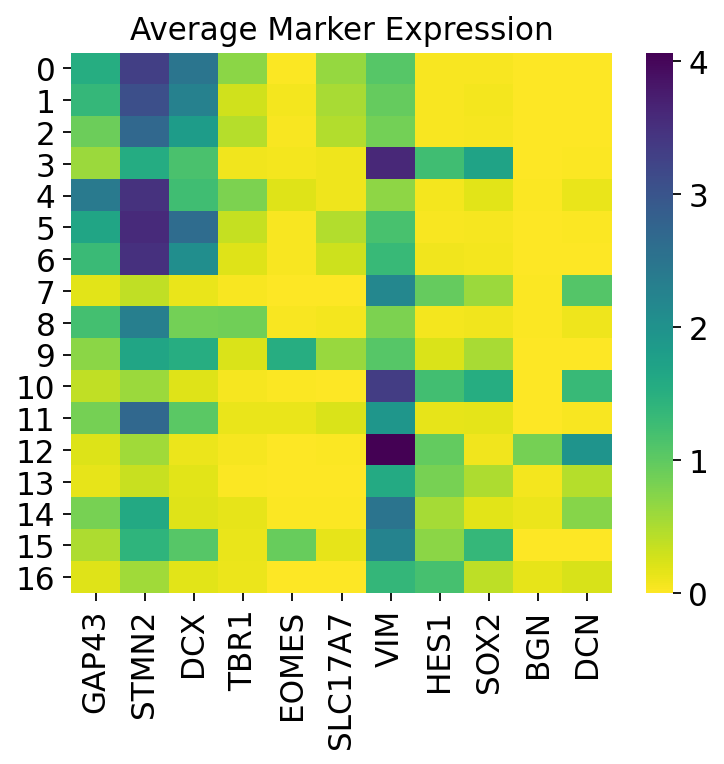

In [5]:
##########################################
### Avergae expression of neuronal and ###
###  non-neuronal markers per cluster  ###
##########################################

# reference: https://scanpy.discourse.group/t/how-to-calculate-the-average-gene-expression-within-each-cluster/126/3
res = pd.DataFrame(columns=adata.var_names, index=adata.obs['clusters'].cat.categories)                                                                                                 

for clust in adata.obs.clusters.cat.categories: 
    res.loc[clust] = adata[adata.obs['clusters'].isin([clust]),:].X.mean(0)
    
res.fillna(0., inplace= True)
res_sub= res[neuronal_markers + non_neuronal_markers]
os.makedirs(f"{save_path}/my_marker/", exist_ok= True)
res_sub.to_csv(f"{save_path}/my_marker/avg_markerexpr_cluster", sep= "\t")

nrows, ncols= 1, 1
scale, ratio= 5., 1
figsize= (nrows*scale, ncols*scale*ratio)
fig, ax= plt.subplots(nrows, ncols, figsize= figsize)
sns.heatmap(res_sub, ax= ax, cmap= color_map.reversed())
ax.set_title("Average Marker Expression")
plt.tight_layout()
fig.savefig("figures/heatmap_avgmarkerexpr_clstr", format= "pdf")

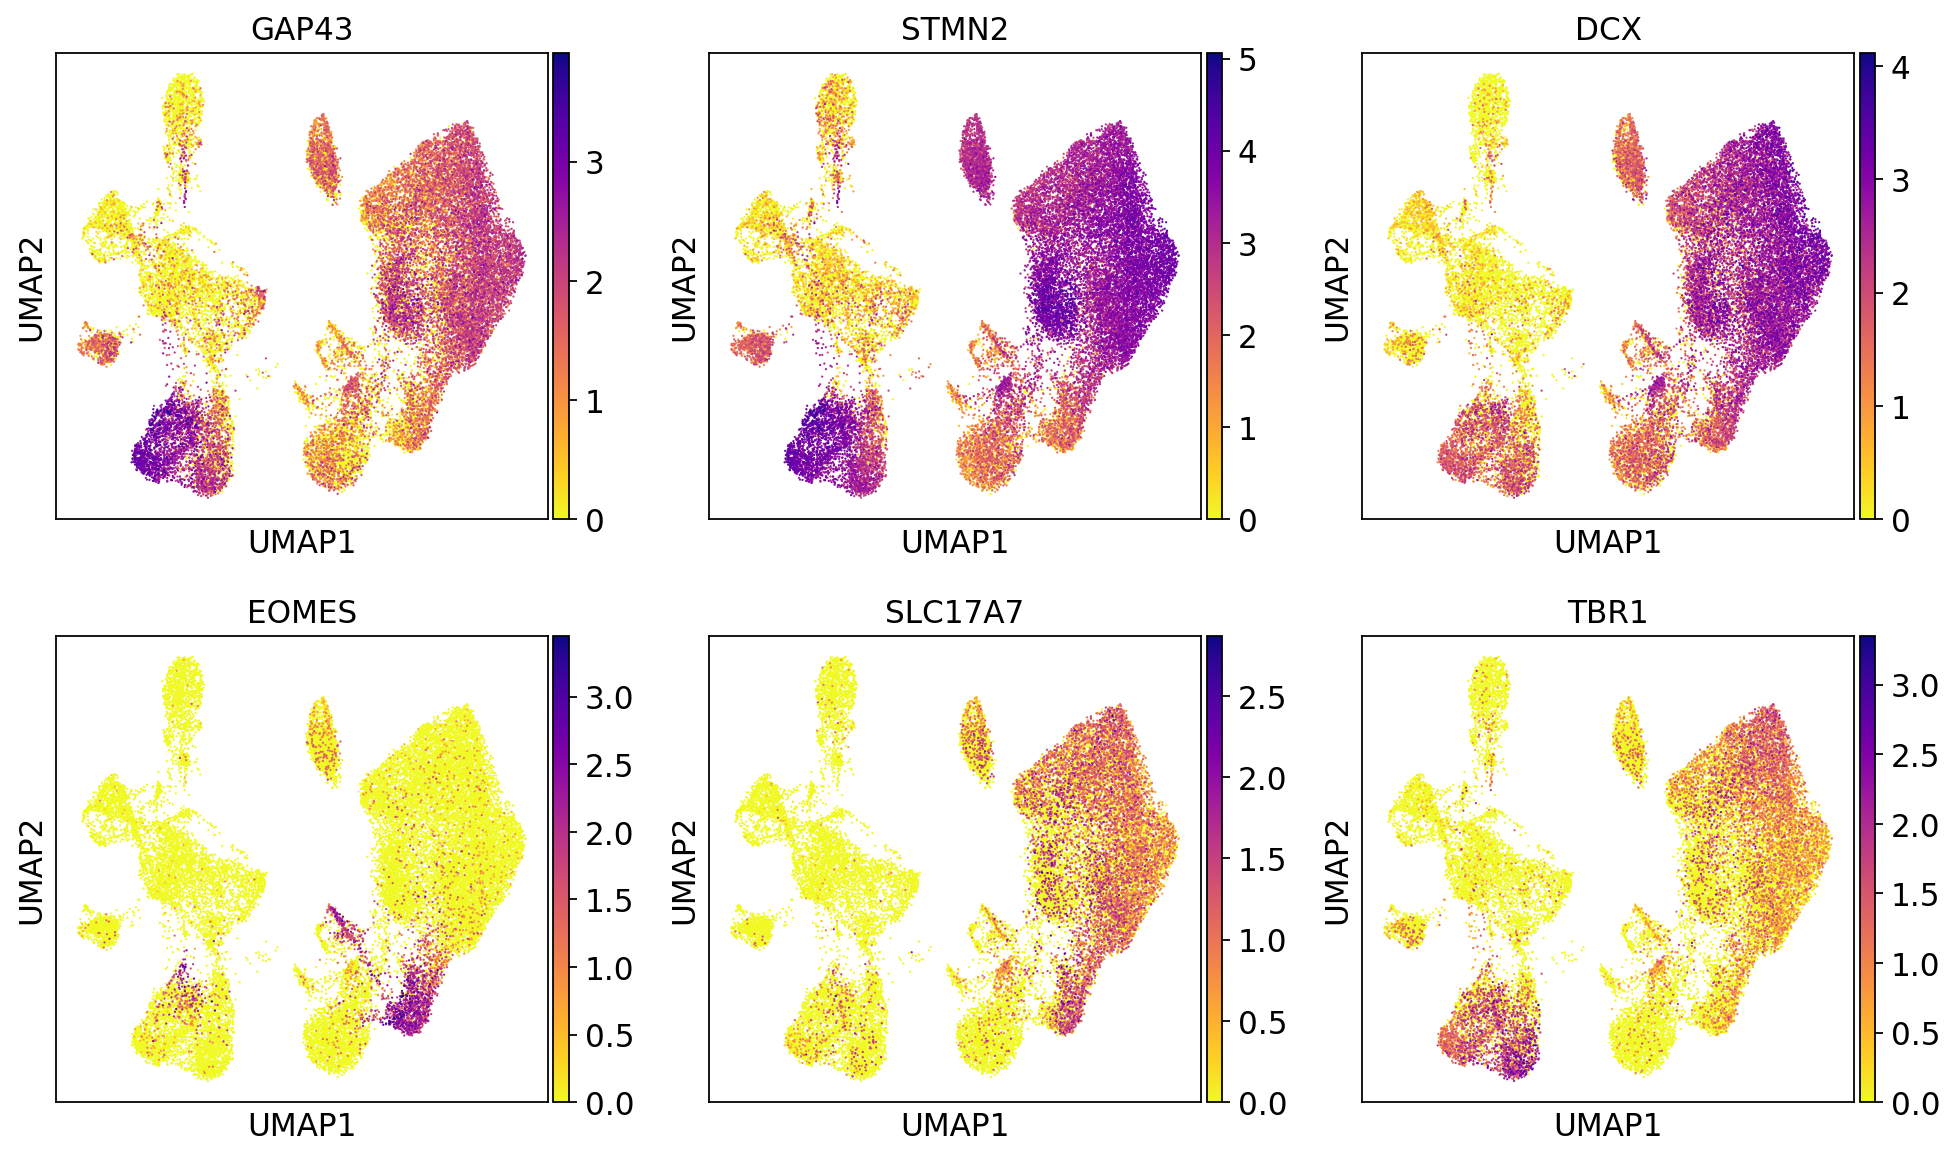

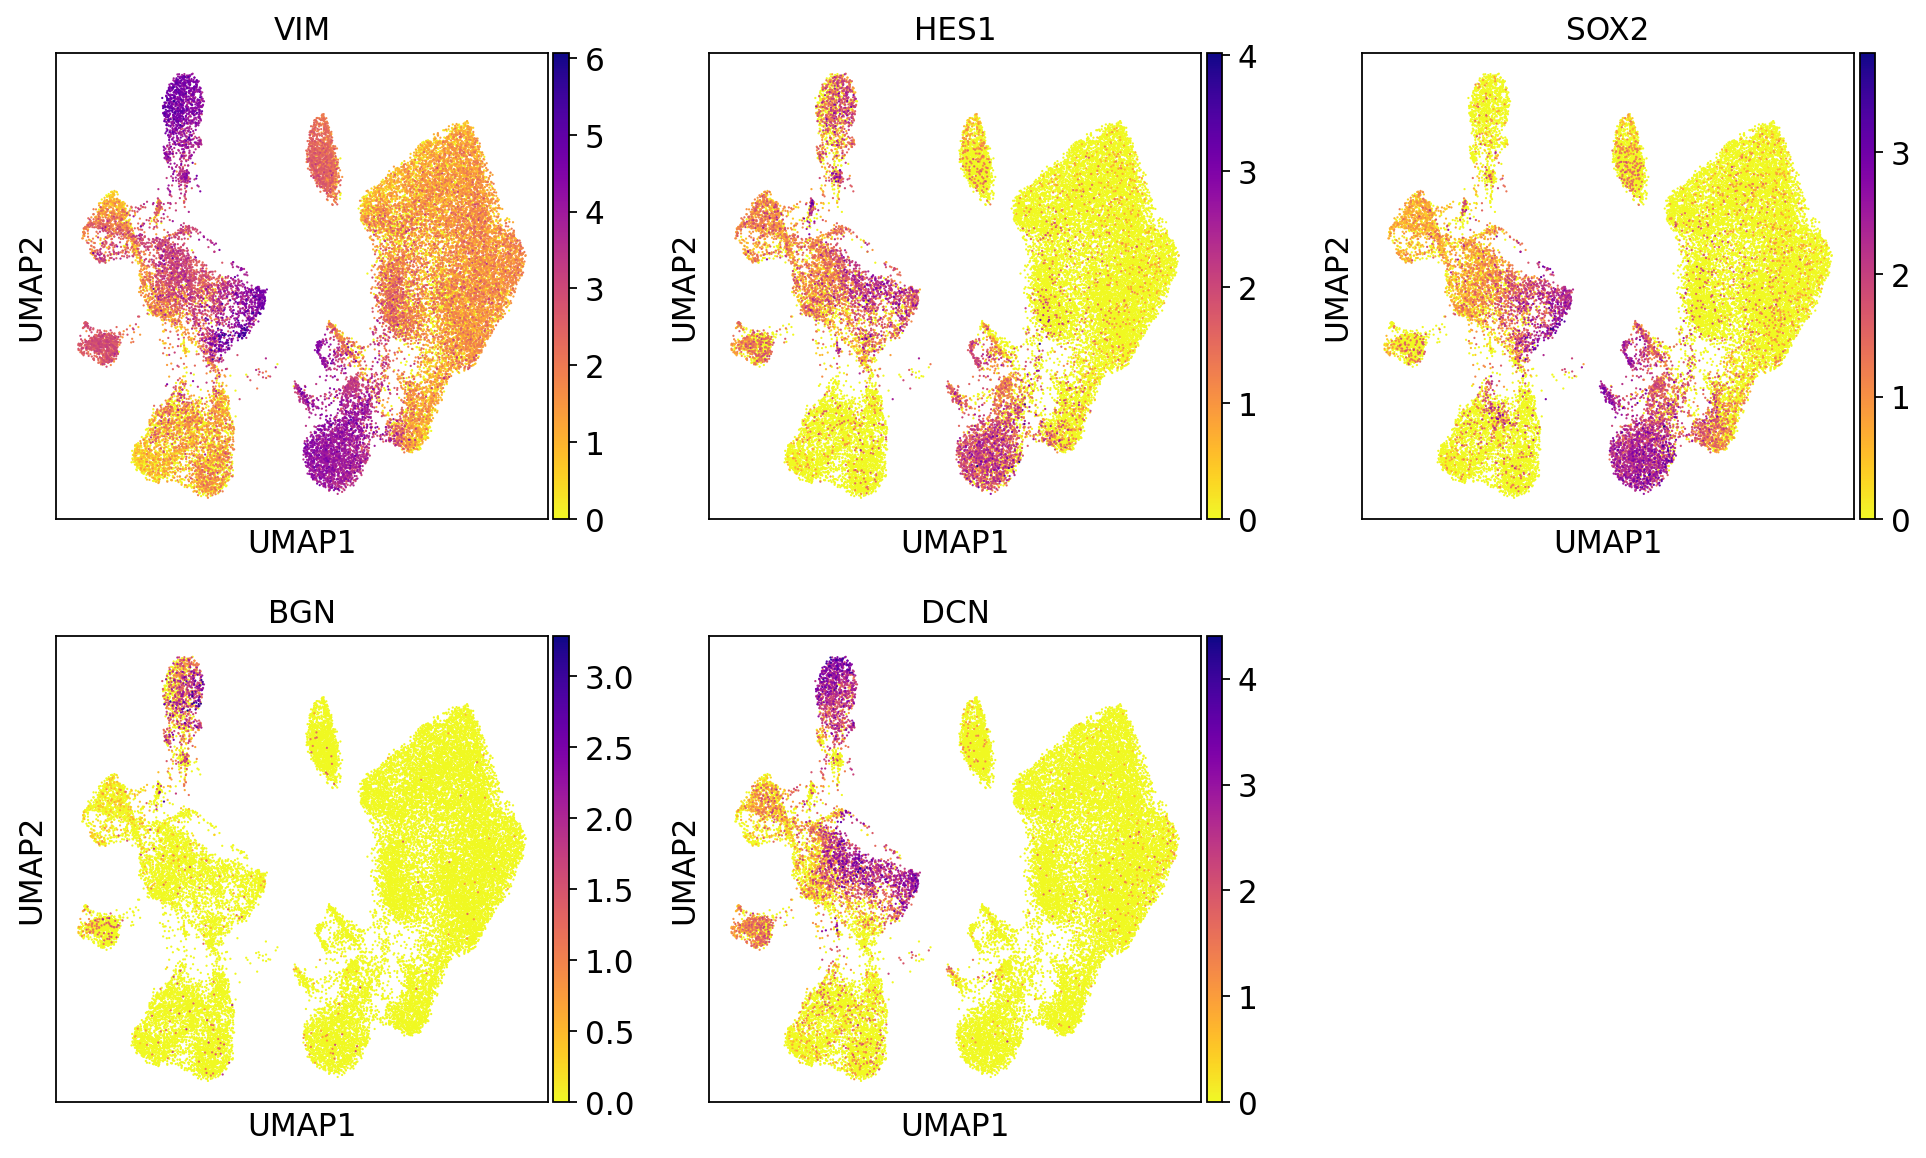

In [6]:
##################################################
### Visualizing the expression of neuronal and ###
###   non-neuronal markers in the umap         ###
##################################################


color_map = plt.cm.get_cmap('plasma').reversed()
# neuronal clusters
_= sc.pl.umap(adata, color=['GAP43', 'STMN2', 'DCX', 'EOMES', 'SLC17A7', 'TBR1'], 
              cmap= color_map, ncols= 3, save= "_neu_markexpr_cellfilter", show= True)
# nonneuronal clusters
_= sc.pl.umap(adata, color=['VIM', 'HES1', 'SOX2', 'BGN', 'DCN'], cmap= color_map, ncols= 3, 
              show= True, save= "_nonneu_markexpr_cellfilter") # nonneuronal clusters

In [7]:
####################
### saving adata ###
####################

adata.write(results_file) # save the adata object

In [8]:
############################################################
### performing t-test to get the markers of each cluster ###
############################################################

sc.tl.rank_genes_groups(adata, 'clusters', method='t-test', pts= True) # can be repeated with "Cell Type" instead of "clusters"
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, ncols= 4, save= "_markrank_clstr", show= False)

df_dpd_markers= pd.DataFrame(adata.uns['rank_genes_groups']['names'])
df_dpd_marker_pvals= pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
df_dpd_marker_logfc= pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
df_dpd_marker_pts= adata.uns['rank_genes_groups']['pts'].reset_index(drop= True)
# adata.uns['rank_genes_groups']['scores']

print(f"median logfc, {np.median(df_dpd_marker_logfc.values)} --- median pvals, {np.median(df_dpd_marker_pvals.values)}")

df_dpd_markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:20)
median logfc, -0.1917649656534195 --- median pvals, 4.201787435535615e-07


0        1       2        3         4        5       6        7  \
0        SOX4    SOX11  HMGCS1      VIM    PCSK1N  NEUROD6   STMN2      TTR   
1       GRIA2  NEUROD6    SQLE    SFRP1      RELN    STMN2  TUBA1A    RPS26   
2        NFIB   TUBA1A   MSMO1    TTYH1     GAP43    SOX11   RPL39    RPL41   
3        SYT1     NFIB  MALAT1      PTN     RSPO3   ZBTB18   RPL26     PCP4   
4         DCX     SOX4    PCLO  C1orf61      RTN1      DCX   RPL30     CD63   
...       ...      ...     ...      ...       ...      ...     ...      ...   
13482     CLU    SULF1    EGR1   IGFBP7       SLA   IFITM3  CXCL14    NCAM1   
13483  CXCL14   IFITM3    PCP4     RBP1  C14orf23   CXCL14  MALAT1      DCX   
13484  IFITM3   CXCL14  CXCL14     PCP4   NEUROD2     RBP1     FOS  NEUROD2   
13485  RPS4Y1   RPS4Y1  RPS4Y1   RPS4Y1   NEUROD6   RPS4Y1  RPS4Y1    FOXG1   
13486     TTR      TTR     TTR      TTR     FOXG1      TTR     TTR  NEUROD6   

              8        9       10        11         12       13        14  \
0           TTR  C1orf61      CLU     RPS19     COL1A2      TTR       TTR   
1          BTG1     HES6     CD63     RPL13     COL3A1     RBP1    MT-ND3   
2          LHX1     SOX4      VIM     RPL32     LGALS1   IGFBP7     RPLP1   
3       MAB21L1  HNRNPA1      WLS     RPS18        VIM    SERF2     SERF2   
4          PCP4  GADD45G     SOX2     RPL11     COL1A1  RARRES2       FTL   
...         ...      ...      ...       ...        ...      ...       ...   
13482     MEIS2   IGFBP7    GRIA2  ANKRD36C  LINC00461   TUBB2B  C14orf23   
13483   NEUROD2     PCP4   ARPP21    PRRC2C    NEUROD2    MEIS2   NEUROD2   
13484  C14orf23   CXCL14  NEUROD2  KCNQ1OT1        DCX  NEUROD2     MEIS2   
13485   NEUROD6   RPS4Y1    FOXG1    MALAT1    NEUROD6    FOXG1     FOXG1   
13486     FOXG1      TTR  NEUROD6    RPS4Y1      FOXG1  NEUROD6   NEUROD6   

           15        16  
0       HMGB1       TTR  
1       HMGB2    MALAT1  
2      TUBA1B     NEAT1  
3       HMGN2     HTR2C  
4       H2AFZ     SULF1  
...       ...       ...  
13482  RPS4Y1  C14orf23  
13483    PCP4    TCEAL7  
13484   HTR2C     MEIS2  
13485  CXCL14     FOXG1  
13486     TTR   NEUROD6  

[13487 rows x 17 columns]

In [9]:
######################################
### subset the markers per cluster ###
###    by logfc and pval criteria  ###
######################################

# Keep the markers with pval< 0.05 and logfc > 0.25
mask_fc= df_dpd_marker_logfc > 0.25
mask_pval= df_dpd_marker_pvals < 0.05

mask= mask_fc.values * mask_pval.values # * mask_pts.values
df_dpd_marker_masked= df_dpd_markers*mask

marker_per_cluster= {}
for col in range(df_dpd_marker_masked.shape[1]):
    genes= df_dpd_marker_masked.iloc[:, col]
    genes = [ x for ctr, x in enumerate(genes) if x!="" ]
    marker_per_cluster[col]= list(genes)
    print(f"cls{col}, markers {len(genes)}, {list(genes)[:10]}")

cls0, markers 7480, ['SOX4', 'GRIA2', 'NFIB', 'SYT1', 'DCX', 'ARPP21', 'STMN2', 'MAP1B', 'SOX5', 'NEUROD6']
cls1, markers 3757, ['SOX11', 'NEUROD6', 'TUBA1A', 'NFIB', 'SOX4', 'NEUROD2', 'TUBB2B', 'TCF4', 'ARHGAP21', 'MEIS2']
cls2, markers 3870, ['HMGCS1', 'SQLE', 'MSMO1', 'MALAT1', 'PCLO', 'IDI1', 'FDFT1', 'HMGCR', 'GRIA2', 'SOX4']
cls3, markers 3488, ['VIM', 'SFRP1', 'TTYH1', 'PTN', 'C1orf61', 'PTPRZ1', 'ID4', 'SOX2', 'FABP7', 'QKI']
cls4, markers 4565, ['PCSK1N', 'RELN', 'GAP43', 'RSPO3', 'RTN1', 'CALM1', 'TXN', 'TTR', 'CALB2', 'STMN1']
cls5, markers 6087, ['NEUROD6', 'STMN2', 'SOX11', 'ZBTB18', 'DCX', 'NEUROD2', 'TUBA1A', 'FABP7', 'ARPP21', 'GPM6A']
cls6, markers 462, ['STMN2', 'TUBA1A', 'RPL39', 'RPL26', 'RPL30', 'RPL32', 'TMSB10', 'RPS8', 'RPS13', 'YBX1']
cls7, markers 3679, ['TTR', 'RPS26', 'RPL41', 'PCP4', 'CD63', 'RPLP1', 'RBP1', 'RPS6', 'HTR2C', 'CXCL14']
cls8, markers 3878, ['TTR', 'BTG1', 'LHX1', 'MAB21L1', 'PCP4', 'RELN', 'CNTNAP2', 'CRABP1', 'ZNF503', 'NR2F2']
cls9, marker

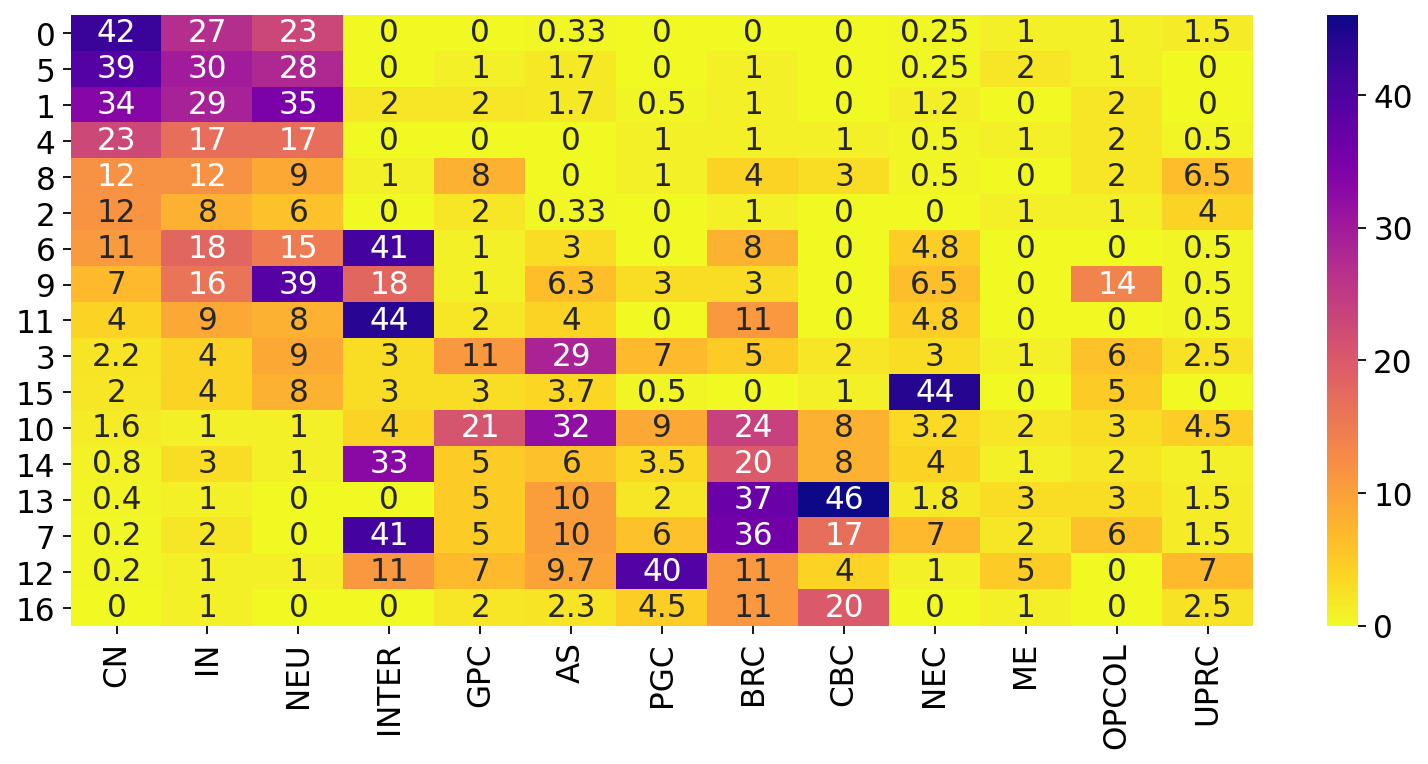

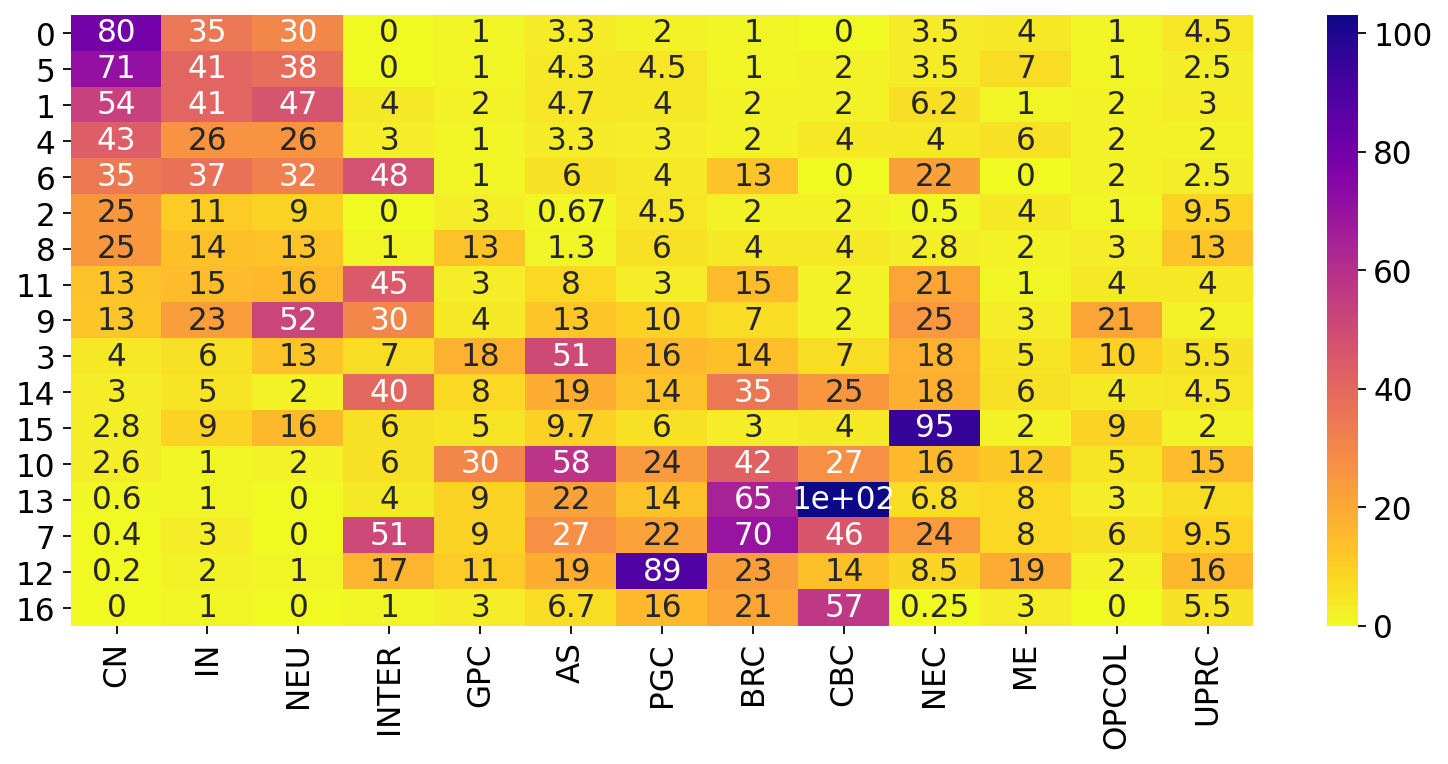

In [10]:
################################################################
###           Overlap of statistically derived markers       ###
###  between DPD deficiency dataset and Tanaka et al. study  ###
################################################################

# read the brain/organoid markers from ucsc database (paper: https://pubmed.ncbi.nlm.nih.gov/32049002/, Tanaka et al.)
marker_brain_dict= {}
mypath= "dpd_data/ucsc_brainorganoid_tanaka"

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for f in onlyfiles:
    df= pd.read_csv(f"{mypath}/{f}", sep= "\t")
    CT_name= f.split('.')[0]
    marker_brain_dict[CT_name]= list(df["symbol"])


# take the common markers between every per of (cluster, cell type) from my analysis and tanaka paper
top_lst= [(100, 100), (200,200)]
for (top_mine, top_brain) in top_lst:
    nested_dict= {}
    # saving my markers per cluster 
    os.makedirs(f"{save_path}/my_marker/top{top_mine}", exist_ok= True)
    for clstr, my_marker in marker_per_cluster.items():
        my_marker_top= my_marker[:top_mine]
        my_marker_2fille= "\n".join(list(my_marker_top))
        file= open(f"{save_path}/my_marker/top{top_mine}/cls{clstr}", "w")
        file.write(my_marker_2fille)
        file.close()

        nested_dict[clstr]= {}
        for ct, marker_ct in marker_brain_dict.items():
            marker_ct_top= marker_ct[:top_brain]
            marker_comm= set(marker_ct_top) & set(my_marker_top)
            nested_dict[clstr][ct]= len(marker_comm)
            
    coarse_cts= ['AS', 'BRC', 'CBC', 'CN', 'GPC', 'Inter', 'IN', 'ME', 'NEC', 'Neuron', 'OPCOL', 'PGC', 'UPRC']
    nested_dict_coarse= {}

    for clstr, dict_  in nested_dict.items():
        nested_dict_coarse[clstr]= {}
        for ct in coarse_cts:
            ct_count= 0
            nested_dict_coarse[clstr][ct]= 0
            for key, value in dict_.items():
                if ct in key:
                    ct_count= ct_count + 1
                    nested_dict_coarse[clstr][ct]= nested_dict_coarse[clstr][ct] + value
            nested_dict_coarse[clstr][ct]= nested_dict_coarse[clstr][ct]/ct_count
            #print(f"ct {ct}, ct_count {ct_count}")
            
    df_nested= pd.DataFrame.from_dict(nested_dict, orient='index')
    df_nested_coarse= pd.DataFrame.from_dict(nested_dict_coarse, orient='index')
    col_order= ["CN", "IN", "Neuron", "Inter", "GPC", "AS", "PGC", "BRC", "CBC", "NEC", "ME", "OPCOL", "UPRC"]
    df_= df_nested_coarse[col_order].sort_values(by= ["CN"], ascending= False)
    # rename columns
    df_.columns= ["CN", "IN", "NEU", "INTER", "GPC", "AS", "PGC", "BRC", "CBC", "NEC", "ME", "OPCOL", "UPRC"]
    df_.to_csv(f"{save_path}/my_marker/coarse_overlap_final{top_mine}", sep = "\t")
    
    nrows, ncols, scale, ratio= 1,1,5,2
    color_map = plt.cm.get_cmap('plasma').reversed()
    fig, ax= plt.subplots(1, 1, figsize= (ncols*scale*ratio, nrows*scale))
    sns.heatmap(df_, cmap= color_map, annot= True, ax= ax)
    plt.tight_layout()
    fig.savefig(f"figures/marker_overlap_{top_mine}", format= "pdf")

In [11]:
###################################################
###   save the processed single cell data for   ### 
#  signature/mixture generation for deconvolution #
###################################################

if not load_adata:
    """
        We did not save adata_unnorm, therefore you can run this cell
        only if adata is constructed from scratch and not loaded from the paper analysis.
        In case paper adata is used, you can access `all_proc`, `dpd_phenoData`, 
        and `cells_perclstr` from `dpd_data/processed_data` directory, downloaded 
        from google drive, for signature generation and pseudobulk mixtures.
    """

    # attention: make sure to save the counts not the transformed counts
    adata_unnorm.obs["clusters"]= adata.obs["clusters"]
    adata_unnorm_dense= adata_unnorm.X.toarray()
    df_data= pd.DataFrame(adata_unnorm_dense, index= adata_unnorm.obs.index, columns= adata_unnorm.var.index)

    if not os.path.exists(f"{save_path}/processed_data/all_proc"):
        os.makedirs(f"{save_path}/processed_data/", exist_ok= True)
        df_data.to_csv(f"{save_path}/processed_data/all_proc", sep= "\t")
        

    # create full_phenoData which contains all cells (regardless of them being from healthy or dpd)
    # cellID	cellType	sampleID are the columns, and the rows are the cells

    def no2group(x):
        if int(x.strip().split("-")[1]) in [4,5,6]:
            grp= "dpd"
        else:
            grp= "h"
        return grp

    phenoData= adata_unnorm.obs[["clusters"]]
    phenoData["cellID"]= phenoData.index
    phenoData["sampleID"]= phenoData["cellID"].apply(no2group)
    phenoData= phenoData[["cellID", "clusters", "sampleID"]]
    phenoData.columns= ["cellID", "cellType", "sampleID"]

    os.makedirs(f"{save_path}/processed_data/", exist_ok= True)
    phenoData.to_csv(f"{save_path}/processed_data/dpd_phenoData", sep= "\t", index= False)
    
    phenoData_d= phenoData[phenoData["sampleID"] == "dpd"]
    clstr_d_count= phenoData_d['cellType'].value_counts().sort_index()

    phenoData_h= phenoData[phenoData["sampleID"] == "h"]
    clstr_h_count= phenoData_h['cellType'].value_counts().sort_index()

    df_clstr_counts= pd.DataFrame([clstr_d_count, clstr_h_count], index= ["dpd", "h"]).T
    df_clstr_counts.sort_index(inplace= True)
    df_clstr_counts.to_csv(f"{save_path}/processed_data/cells_perclstr", sep= "\t")